# Example ilustrating implementation of custom problem

In [157]:

import sys
sys.path.append(".")
sys.path.append("../bindings/python")
import oofempy
import util # some utility functions 
import numpy as np


Create custom problem represented by a python! class derived from EngngModel 

In [158]:

class MyProblem(oofempy.EngngModel):
    def __init__(self, num, master):
        oofempy.EngngModel.__init__(self, num, master)
        self.ndomains = 1
        self.en=oofempy.EModelDefaultEquationNumbering() 
    def solveYourself(self):
        tStep = oofempy.TimeStep(1,self,1,1,1,1,oofempy.TimeDiscretizationType.TD_Unspecified)
        domain = self.giveDomain(1)
        self.postInitialize() # forces equation numbering
        nelem = domain.giveNumberOfElements()
        nnode = domain.giveNumberOfDofManagers()
        neq=self.giveNumberOfDomainEquations(1,self.en)
        # create working arrays and matrices
        k=oofempy.FloatMatrix(neq,neq)
        f=oofempy.FloatArray(neq)
        self.r=oofempy.FloatArray(neq)
        ke=oofempy.FloatMatrix()
        loc=oofempy.IntArray()
        print("Number of nodes:", nnode, " Number of elements:", nelem, " neq:", neq)
        #assemble stiffness matrix
        for ielem in range(nelem):
            element = domain.giveElement(ielem+1)
            element.postInitialize()
            #print(type(element))
            element.giveCharacteristicMatrix(ke, oofempy.CharType.TangentStiffnessMatrix, tStep)
            element.giveLocationArray(loc,self.en,None)
            k.assemble(ke,loc)
        #apply some loading 
        for i in range(nnode-4+1, nnode+1):
            f[domain.giveDofManager(i).giveDofWithID(oofempy.DofIDItem.D_v).giveEquationNumber(self.en)-1]=1.0
        #solve 
        k.solveForRhs(f,self.r, False)
        print("Displacement vector:", self.r)


In [159]:

problem = MyProblem(1,None) #oofempy.linearStatic(nSteps=1, outFile="test_4.out")
problem.Instanciate_init()
# domain (if no engngModel specified to domain, it is asigned to the last one created)
domain = oofempy.domain(1, 1, problem, oofempy.domainType._2dPlaneStressMode, tstep_all=True, dofman_all=True, element_all=True)
problem.setDomain(1, domain, True)



Generate problem domain programatically

In [160]:

ltf1 = oofempy.peakFunction(1, domain, t=1, f_t=1)
ltfs = (ltf1, )

# boundary conditions
# loadTimeFunction parameter can be specified as int value or as LoadTimeFunction itself (valid for all objects with giveNumber() method)
bc1   = oofempy.boundaryCondition(    1, domain, loadTimeFunction=1, dofs=(1,2), values=(0,0), set=1)
n2    = oofempy.nodalLoad(            2, domain, loadTimeFunction=1,    components=(0,-10.), dofs=(1,2), set=2)
bcs = (bc1, n2)



In [161]:


# material and cross section
mat = oofempy.isoLE(1, domain, d=1., E=30., n=0.2, tAlpha=1.2e-5)
cs  = oofempy.simpleCS(1, domain, area=0.5, Iy=0.01, beamShearCoeff=1.e18, thick=0.5)

# nodes
# if one value is passed as parameter where oofem expects array of values, it must be passed as tuple or list (see load in n4)
nodes = []
nn=0
h=1
l=10
nelemh = 4
neleml = 10
for i in range(neleml):
    for j in range(nelemh):
        nn+=1
        nodes.append(oofempy.node(nn, domain, coords=(i*(l/neleml), j*(h/nelemh), 0.)))

# elements
elements=[]
ne=0
for i in range(neleml-1):
    for j in range(nelemh-1):
        ne+=1
        n1 = 1+i*nelemh+j
        n2 = n1+nelemh
        n3 = n2+1
        n4 = n1+1
        elements.append(oofempy.planeStress2d(ne, domain, nodes=(n1,n2,n3,n4), mat=1, crossSect=1))

s1 = oofempy.createSet(1, domain, nodes=tuple(range(1,nelemh+1))) 
s2 = oofempy.createSet(2, domain, nodes=tuple(range(neleml*(nelemh-1)+1, neleml*nelemh+1))) 

# setup domain
util.setupDomain (domain, nodes, elements, (cs,), (mat,), bcs, (), ltfs, (s1,s2))



Solve the custom problem

In [162]:

problem.solveYourself()


Number of nodes: 40  Number of elements: 27  neq: 72
Displacement vector: <oofempy.FloatArray: {23.8109, 33.2485, 7.81331, 32.2776, -7.81331, 32.2776, -23.8109, 33.2485, 45.0374, 125.658, 15.0321, 125.05, -15.0321, 125.05, -45.0374, 125.658, 63.489, 271.193, 21.0779, 270.615, -21.0779, 270.615, -63.489, 271.193, 79.0212, 461.988, 26.3233, 461.518, -26.3233, 461.518, -79.0212, 461.988, 91.7893, 690.527, 30.5373, 690.149, -30.5373, 690.149, -91.7893, 690.527, 101.682, ...}>


In [163]:
# simple postprocessing, see https://newbedev.com/how-can-i-plot-2d-fem-results-using-matplotlib
import matplotlib.pyplot as plt
import matplotlib.tri as tri


# plots a finite element mesh
def plot_fem_mesh(nodes_x, nodes_y, elements, color='black'):
    for element in elements:
        x = [nodes_x[element[i]] for i in range(len(element))]
        y = [nodes_y[element[i]] for i in range(len(element))]
        plt.fill(x, y, edgecolor=color, fill=False)


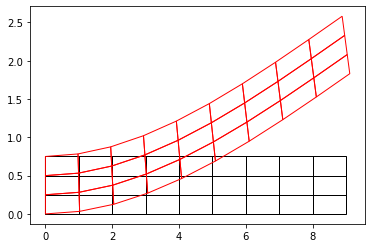

In [164]:

nodes_x=[]
nodes_y=[]
elements=[]

nelems = domain.giveNumberOfElements()
nnodes = domain.giveNumberOfDofManagers()
for i in range(nnodes):
    c=domain.giveDofManager(i+1).giveCoordinates()
    nodes_x.append(c[0])
    nodes_y.append(c[1])
for i in range(nelems):
    nodes = list(domain.giveElement(i+1).giveDofManArray())
    nodes[:] = [x - 1 for x in nodes]
    elements.append(list(nodes))

#plot geometry
plot_fem_mesh(nodes_x, nodes_y, elements)

#plot deformed shape
scale=0.001
for i in range(nnodes):
    node = domain.giveDofManager(i+1)
    equ = node.giveDofWithID(oofempy.DofIDItem.D_u).giveEquationNumber(problem.en)
    if (equ):
        nodes_x[i]+=problem.r[equ-1]*scale
    eqv = node.giveDofWithID(oofempy.DofIDItem.D_v).giveEquationNumber(problem.en)
    if (eqv):
        nodes_y[i]+=problem.r[eqv-1]*scale
plot_fem_mesh(nodes_x, nodes_y, elements, "red")

